In [23]:
%pip install statsmodels
%pip install matplotlib
%pip install scikit-learn
%pip install redis-stack-server

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement redis-stack-server (from versions: none)
ERROR: No matching distribution found for redis-stack-server


In [4]:
import sqlite3
from datetime import datetime

conn = sqlite3.connect("dataset.db")
init_date = datetime(2015,11,1)
end_date = datetime(2025,11,1)
eventtype='earthquake'

# Import de dados

In [86]:
from requests import get
from dateutil.relativedelta import relativedelta
import pandas as pd

conn.cursor().execute(f"drop table if exists {eventtype}")

while (init_date < end_date):
    aux_date = init_date + relativedelta(weeks=2) if((init_date + relativedelta(months=1)) < end_date) else end_date
    url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime={init_date.strftime("%Y-%m-%d")}&endtime={aux_date.strftime("%Y-%m-%d")}&eventtype={eventtype}"
    init_date += relativedelta(weeks=2, days=1)
    print(url)
    api_data = get(url).text.split('\n')
    api_data = [element.split('|') for element in api_data]
    api_data = pd.DataFrame(api_data[1:], columns=api_data[0])
    api_data.to_sql(eventtype,conn, if_exists='append',index=False)


https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=2018-07-01&endtime=2018-07-08&eventtype=earthquake
https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=2018-07-09&endtime=2018-07-16&eventtype=earthquake
https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=2018-07-17&endtime=2018-07-24&eventtype=earthquake
https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=2018-07-25&endtime=2018-08-01&eventtype=earthquake
https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=2018-08-02&endtime=2018-08-09&eventtype=earthquake
https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=2018-08-10&endtime=2018-08-17&eventtype=earthquake
https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=2018-08-18&endtime=2018-08-25&eventtype=earthquake
https://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=2018-08-26&endtime=2018-09-02&eventtype=earthquake
https://earthquake.usgs.

Apresentação de Dados do Dataset

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

earthquake_data = pd.read_sql(f"select * from {eventtype}", conn)
earthquake_data["Time"] = pd.to_datetime(earthquake_data["Time"])
earthquake_data['Magnitude'] = pd.to_numeric(earthquake_data['Magnitude'])
print(earthquake_data.columns)

Index(['#EventID', 'Time', 'Latitude', 'Longitude', 'Depth/km', 'Author',
       'Catalog', 'Contributor', 'ContributorID', 'MagType', 'Magnitude',
       'MagAuthor', 'EventLocationName'],
      dtype='object')


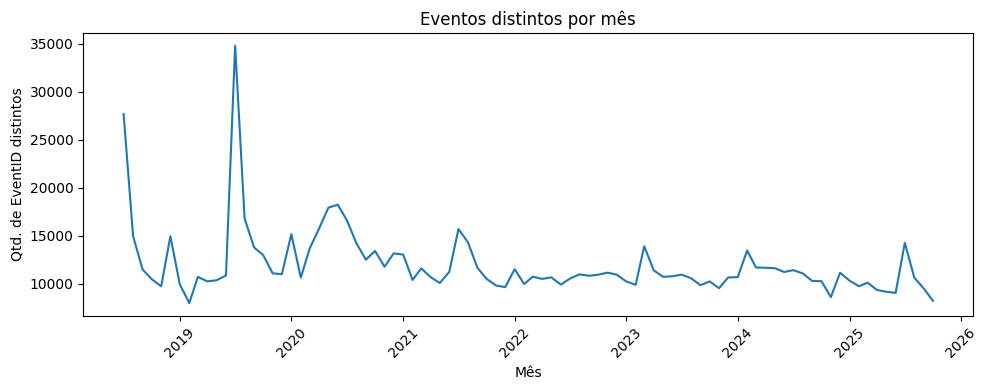

In [88]:
# Quantidade de Eventos por mês no mundo inteiro
qtt_events_per_month = (
    earthquake_data
        .groupby(earthquake_data['Time'].dt.to_period("M"))['#EventID']
        .nunique()
)
qtt_events_per_month.index = qtt_events_per_month.index.to_timestamp()

plt.figure(figsize=(10,4))
plt.plot(
    qtt_events_per_month.index,
    qtt_events_per_month.values
)
plt.xlabel("Mês")
plt.ylabel("Qtd. de EventID distintos")
plt.title("Eventos distintos por mês")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

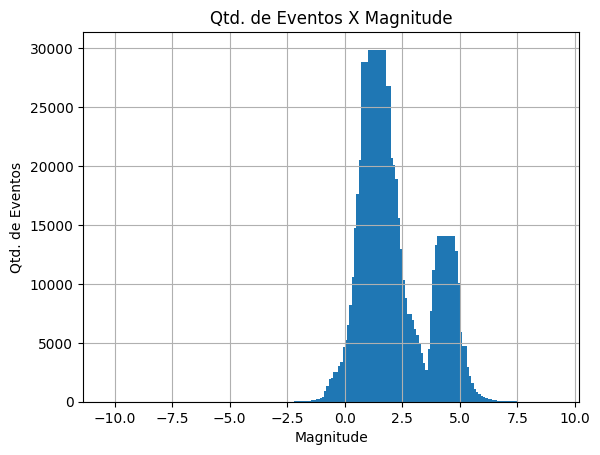

In [89]:
# Quantidade de Eventos X Magnitude em 2 ano

qtt_events_per_magnitude = (
    earthquake_data
        .groupby(earthquake_data['Magnitude'])['#EventID']
        .nunique()
        .sort_index()
)

plt.bar(
    qtt_events_per_magnitude.index,
    qtt_events_per_magnitude.values
)
plt.xlabel("Magnitude")
plt.ylabel("Qtd. de Eventos")
plt.title("Qtd. de Eventos X Magnitude")
plt.grid(True)
plt.show()


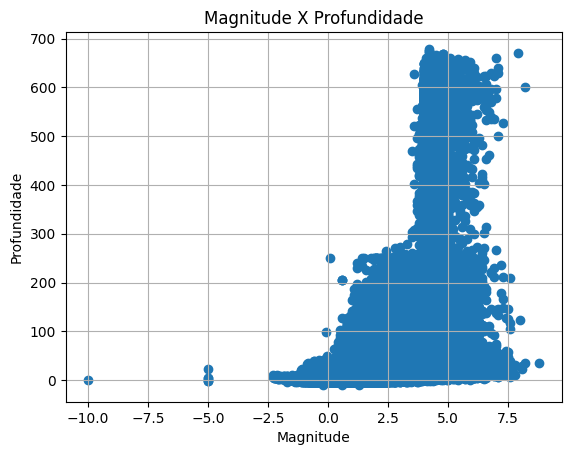

In [90]:
# Magnitude X Profundidade em 2 ano

df_depth_mag = earthquake_data.dropna(subset=['Depth/km'])

plt.scatter(
    df_depth_mag['Magnitude'].astype(float),
    df_depth_mag['Depth/km'].astype(float)
)
plt.ylabel("Profundidade")
plt.xlabel("Magnitude")
plt.title("Magnitude X Profundidade")
plt.grid(True)
plt.show()


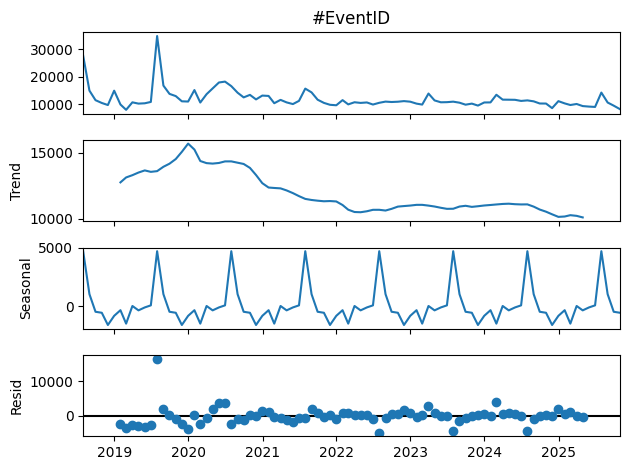

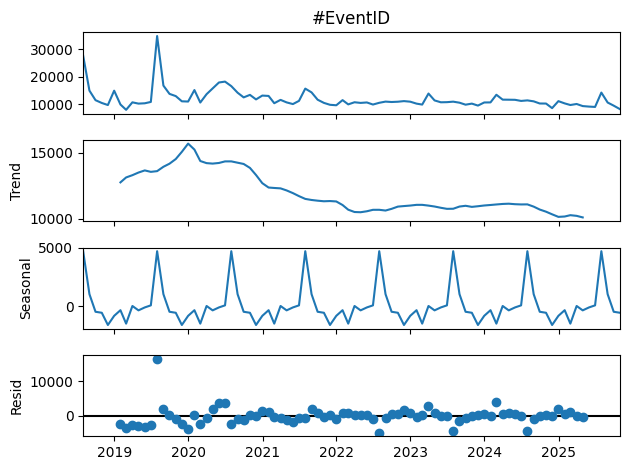

In [12]:
#decomposição estatística (tendencia + sazonalidade + ruído)
from statsmodels.tsa.seasonal import seasonal_decompose

ts = earthquake_data.resample("ME", on="Time")["#EventID"].nunique()
decompose = seasonal_decompose(ts, model='addtive', period=12)
decompose.plot()

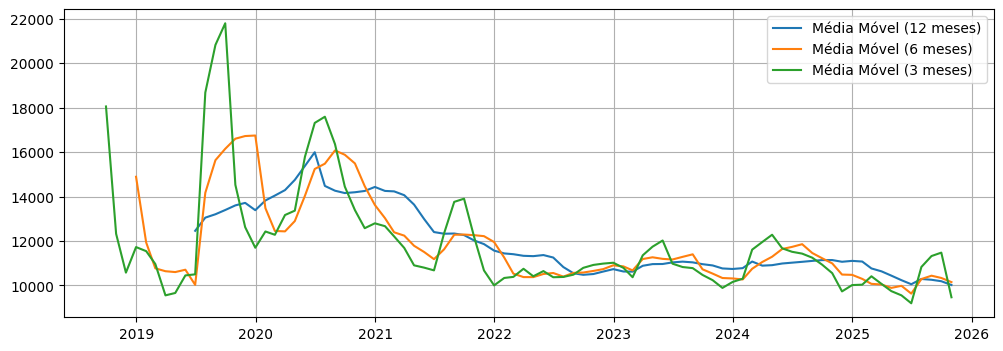

In [14]:
# Apresentação de Média Móvel

moving_avg_12 = ts.rolling(window=12).mean()
moving_avg_6 = ts.rolling(window=6).mean()
moving_avg_3 = ts.rolling(window=3).mean()
plt.figure(figsize=(12,4))
plt.plot(moving_avg_12, label="Média Móvel (12 meses)")
plt.plot(moving_avg_6, label="Média Móvel (6 meses)")
plt.plot(moving_avg_3, label="Média Móvel (3 meses)")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1200x500 with 0 Axes>

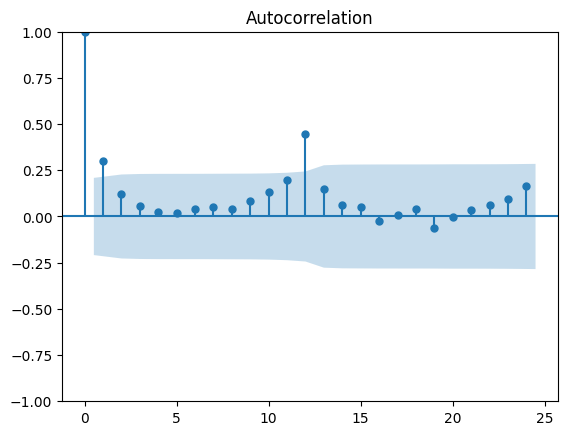

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12,5))
plot_acf(ts, lags=24)
plt.show()

# tem autocorrelação significativa mês-a-mês
# apresenta sazonalidade anual clara
# não apresenta tendência forte no ACF

In [16]:
from statsmodels.tsa.stattools import adfuller
# Teste de Estacionaridade
print("============== Sem Diferenciação ============")
result = adfuller(ts.dropna())
print(f"Estatística ADF: {result[0]}")
print(f"p-value: {result[1]}")
if(result[1] < .05):
    print("A série é estacionária!")
else:
    print("A série não é estacionária!")
print("============== Com Diferenciação ============")
result = adfuller(ts.diff().dropna())
print(f"Estatística ADF: {result[0]}")
print(f"p-value: {result[1]}")
if(result[1] < .05):
    print("A série é estacionária!")
else:
    print("A série não é estacionária!")

============== Sem Diferenciação ============
Estatística ADF: -1.2040701992888434
p-value: 0.671842368696296
A série não é estacionária!
============== Com Diferenciação ============
Estatística ADF: -5.3698818237373995
p-value: 3.917148097048807e-06
A série é estacionária!


88


c:\Users\chris\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\chris\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\chris\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                           #EventID   No. Observations:                   62
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -308.969
Date:                            Sat, 22 Nov 2025   AIC                            627.938
Time:                                    18:56:28   BIC                            635.714
Sample:                                07-31-2018   HQIC                           630.622
                                     - 08-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1073      3.376      0.032      0.975      -6.509       6.724
ma.L1         -0.0737      3.414   

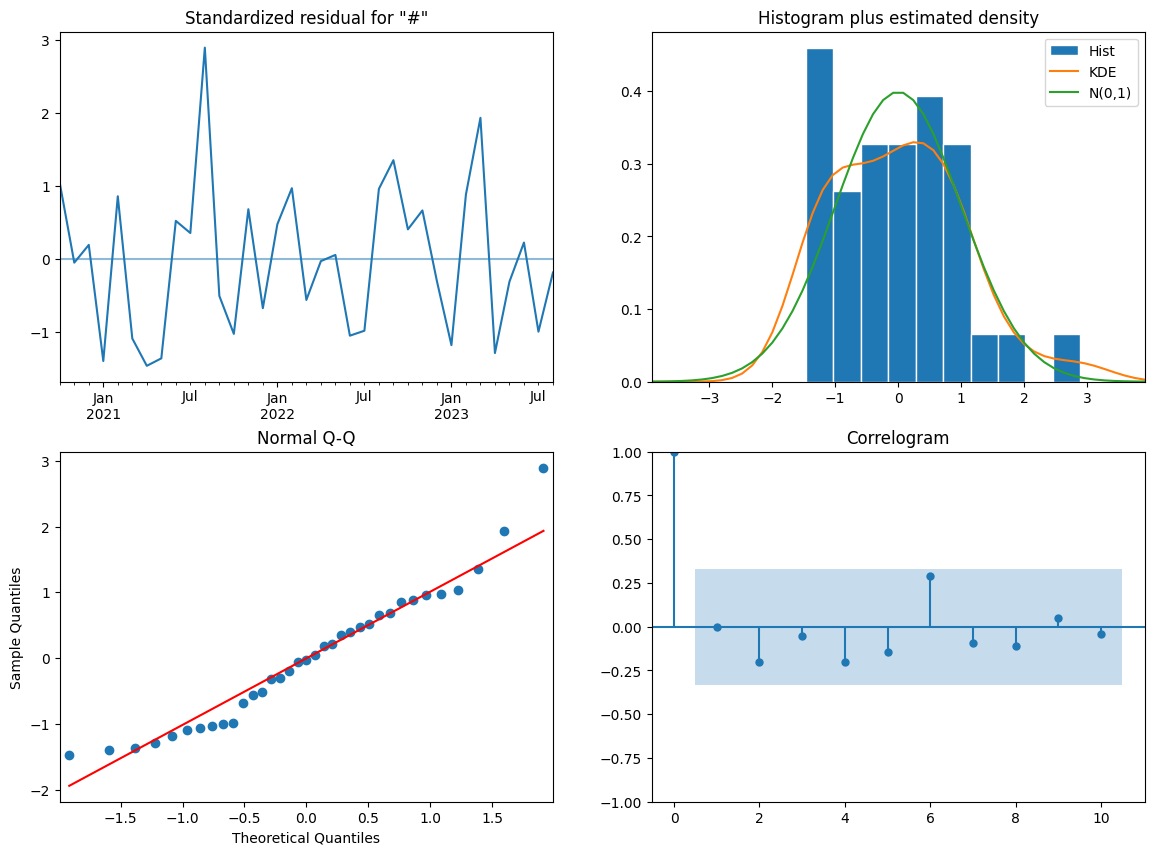

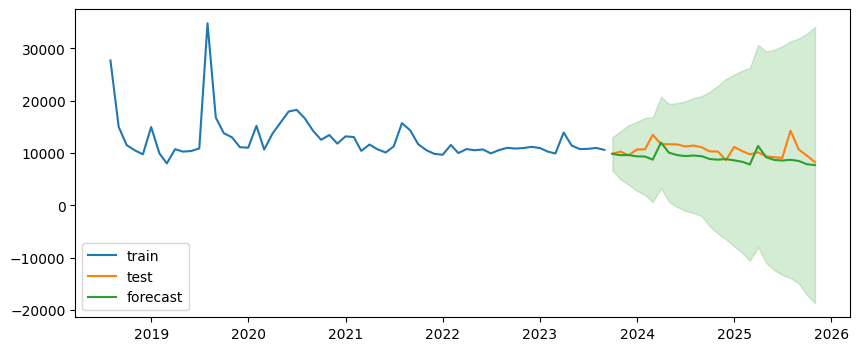

MAE: 1530.0553941827175
RMSE: 1993.979934287544
14.512312126991143 18.91255655929701


In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
print(len(ts))
# Modelagem Preditiva SARIMA

train_end = -26
train = ts.iloc[:train_end]
test = ts.iloc[train_end:]

s=12 # padrão de sazonalidade
p,d,q = 1,1,1
P,D,Q = 1,1,1
model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,s), enforce_invertibility=False, enforce_stationarity=False)
res = model.fit(disp=False)
print(res.summary())
res.plot_diagnostics(figsize=(14, 10))
plt.show()

n_forecast = len(test)
pred = res.get_forecast(steps=n_forecast)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test', color='C1')
plt.plot(pred_mean.index, pred_mean, label='forecast', color='C2')
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='C2', alpha=0.2)
plt.legend(); plt.show()

mae = mean_absolute_error(test, pred_mean)
rmse = math.sqrt(mean_squared_error(test, pred_mean))
print("MAE:", mae)
print("RMSE:", rmse)

mae_percent = mae / test.mean() * 100
rmse_percent = rmse / test.mean() * 100
print(mae_percent, rmse_percent)
